# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = get_dataset("/home/workspace/data/waymo/train/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/waymo/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/waymo/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 74
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    img_info = batch
    img = img_info['image']
    img = PIL.Image.fromarray(img.numpy().astype("uint8"))
    w_img, h_img = img.size # img_info['original_image_spatial_shape'].numpy()
    bbox_lst = img_info['groundtruth_boxes'].numpy()
    classes = img_info['groundtruth_classes'].numpy()
    colors = {1: 'RED', 2:'GREEN', 4:'BLUE'}
        
    draw_img = PIL.ImageDraw.Draw(img)
    for box,class_ in zip(bbox_lst, classes):
        # y1, x1, y2, x2
        w, h = box[2] * h_img, box[3] * h_img
            
        x1 = (box[1] * w_img) #- ((box[2] * h) / 2)    
        y1 = (box[0] * h_img) #- ((box[3] * w) / 2)  
        x2 = (box[3]) * w_img
        y2 = (box[2]) * h_img
        # x1, y1, x2, y2
        draw_img.rectangle([x1, y1, x2, y2], outline=colors[class_])
        
        
#     display(img)
    return img

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

In [4]:
dataset = dataset.shuffle(100)
batch = list(dataset.take(10))

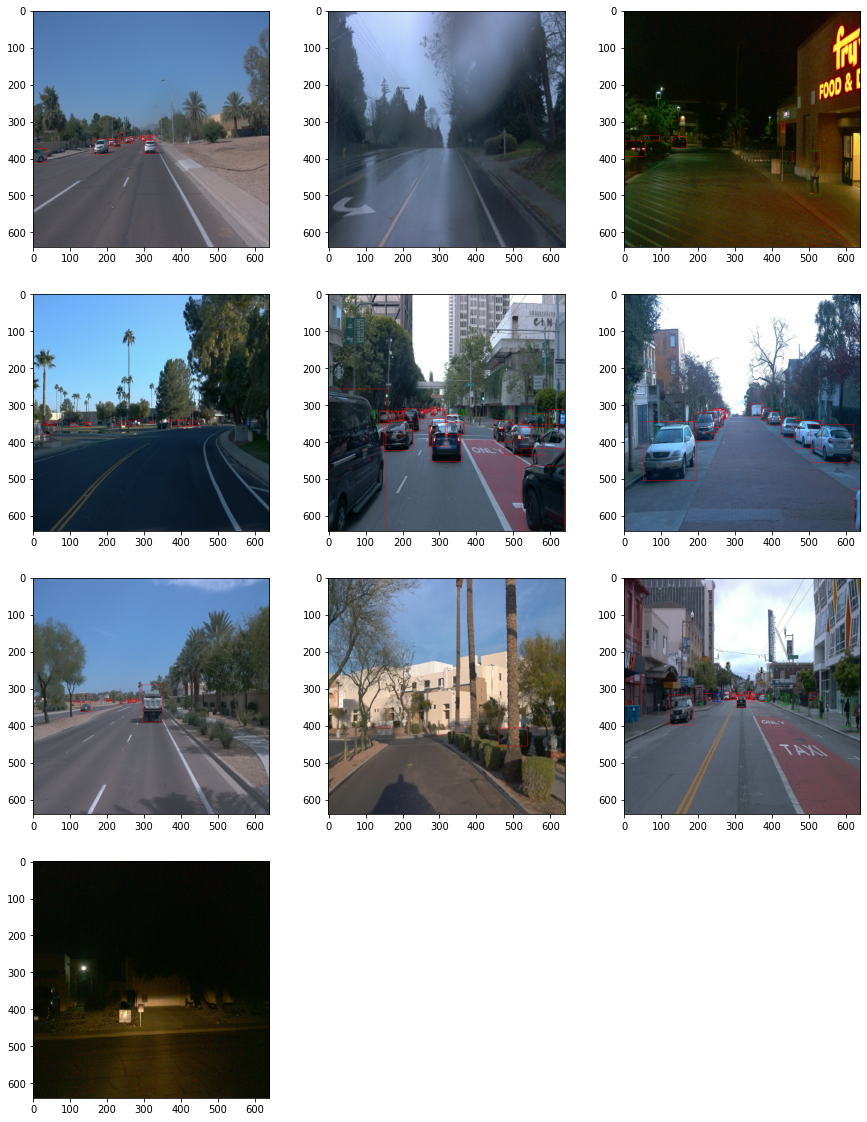

In [5]:
cols, rows = 3, 4
img_count = 10

fig, axes = plt.subplots(rows, cols, figsize=(15, 20))

i = 0
for row in range(rows):
    for col in range(cols):
        if i > img_count - 1:
            break
        axes[row,col].imshow(display_instances(batch[i]))
        i += 1

for ax in axes.flat[10:]:
    ax.remove()

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [6]:
stats = {"Vehicle": 0, "Pedestrian": 0, "Cyclist" : 0}
for rec in dataset.take(1000):
        
    stats['Vehicle'] += rec['groundtruth_classes'].numpy().tolist().count(1)
    stats['Pedestrian'] += rec['groundtruth_classes'].numpy().tolist().count(2)
    stats['Cyclist'] += rec['groundtruth_classes'].numpy().tolist().count(4)
   


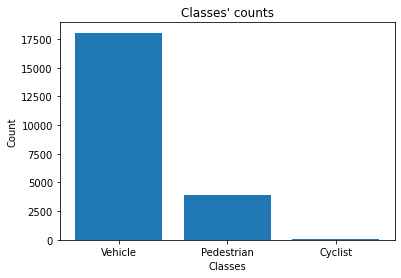

<Figure size 432x288 with 0 Axes>

In [7]:
chart1 = plt
chart1.bar(stats.keys(), stats.values())
chart1.title("Classes' counts")
chart1.xlabel('Classes')
chart1.ylabel('Count')
chart1.show()
plt.savefig('./classes_counts.jpg')

As we can see, we have biased dataset towards vehicles, 
which have many ways to overcome, 

1- Through loss function, by using focal loss
2- Through augmentation, by replicating the dataset, or includes
new images of black backgrounds, or using copyPaste and so on

We'll implement some augmentation to help us overcome this bias, 
also by observing some of the images above, doing random cut 
will help the model not to focus alwyas on the streat, instead, look
for other objects (hypothesis), also some noise might help i.e. gaussian
noise, as the dataset includes image of different circumstances

### Cross validation